# Тестовое задание
#### Выполнил: Нистратов Д.Г. гр.9383 

## Цель работы 
Использованием библиотек Python для кластеризации музыкальных сигналов.
## Задачи лабораторной работы
1. Индивидуальное творческое соревнование.
2. Самостоятельное освоение одного из важных методов обучения без учителя — обучение без учителя.
3. Практическое применение дискретного преобразования Фурье для извлечения признаков обучения.
4. Использованием библиотек Python для кластеризации музыкальных сигналов.

##  Кластеризация

### Загрузка аудио сигнала

In [1]:
from pydub import AudioSegment
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft
from sklearn.cluster import KMeans
import os

def read_mp3(name):
    sound = AudioSegment.from_mp3(name)

    samples = np.array(sound.get_array_of_samples())

    signal = np.array((samples[0::2] + samples[1::2])/2)
    return signal

sounds = []
names = []

for filename in sorted(os.listdir('./mp3/')) :
    if filename.endswith(".mp3"):
        sounds.append(read_mp3(os.path.join('./mp3/', filename)))
        names.append(filename)

sounds = np.array(sounds, dtype=object)

framerate = 44100
N = 256

### Обработка сигнала

Функция split - разбивает сигнал на временные интервалы (кадры) одинаковой длины N отсчетов sm(i), где m— номер кадра.

Функция window - для каждого подходящего кадра проводится предварительное оконное преобразование, чтобы уменьшить искажения при последующем вычислении ДПФ (модель сигнала):
ˆm(i) = sm(i)w(i).
В качестве оконной функции w(i) используется функции Хемминга.

Функция dft и ampSpectrum - для каждого подходящего кадра ˆm вычисляется амплитудный спектр Sm(k).

Функция averageSpec - формирует вектор среднего спектра по всем подходящим кадрам.

In [2]:
def split(signal):
    split_signal = np.array_split(np.array(signal, dtype=np.float64), N)
    return split_signal

In [3]:
def window(split_signal, maximum):
    split_signal = np.array([interval * np.hamming(len(interval)) for interval in split_signal], dtype=object)
    return split_signal

In [4]:
def dft(split_signal, maximum):
    dftValues = np.array([scipy.fft.fft(interval, n=N) for interval in split_signal], dtype=object)
    return dftValues

In [5]:
def ampSpectrum(dftValues):
    amplitudeSpectrum = np.array([np.absolute(interval[:len(interval)//2]) for interval in dftValues], dtype=object)
    return amplitudeSpectrum

In [6]:
def averageSpec(amplitudeSpectrum):
    averageSpectrum = []
    for interval in amplitudeSpectrum:
        averageSpectrum.append(np.average(interval))
    return averageSpectrum

### Кластеризация

Произведем обработку сигнала для каждого звука.

In [7]:
klaster = []
for signal in sounds:
    maximum = np.max(signal)
    split_signal = split(signal)
    split_signal = window(split_signal, maximum)
    dftValues = dft(split_signal, maximum)
    amplitudeSpectrum = ampSpectrum(dftValues)
    averageSpectrum = averageSpec(amplitudeSpectrum)
    klaster.append(averageSpectrum)


Для кластеризации воспользуемся библиотекой sklearn

In [8]:
from sklearn.decomposition import PCA

klaster = np.array(klaster)

Функция выполняет седующие шаги :
1. Задаем количество кластеров, k (положим k = 5).
2. Инициализация центроидов. Случайным образом выбираются k точек данных и объявляются центрами кластеров (центроидами). Здесь возможны различные стратегии выбора (творческий выбор).
3. Разбиение на кластеры. Для каждого элемента набора определяется ближайший к нему центр кластера (расстояния измеряются в метрике Евклида).
4. Вычисление новых центроидов Новые центроиды — это вектора, компоненты которыхпредставляют собой средние значения соответствующих признаков, вычисленные по всем элементам соответствующего кластера.
5. Повторяем шаги 3 — 4

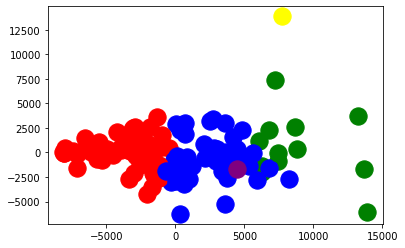

In [9]:
k = 5
colors = ['Green', 'Red', 'Blue', 'Yellow', 'Purple']
kmeans = KMeans(n_clusters=k, random_state=0).fit(klaster)

cluster = [[], [], [], [], []]
reduced_data = PCA(n_components=2).fit_transform(klaster)
for item, label in zip(reduced_data, kmeans.labels_):
    plt.scatter(item[0], item[1], s=300, color=colors[label])
    cluster[label].append(item)

###  Метрика качества

Для определения метрики качества высчитаем цетроиды

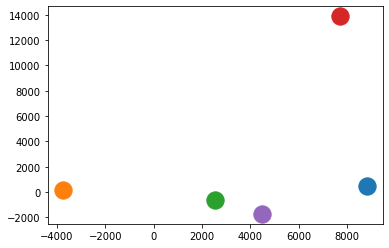

In [10]:
from sklearn.neighbors import NearestCentroid
clf = NearestCentroid()
clf.fit(reduced_data, kmeans.labels_)

pca = PCA(n_components=2).fit_transform(clf.centroids_)
for item in clf.centroids_:
    plt.scatter(item[0], item[1], s=300)

Метрика Компактность кластеров (Cluster Cohesion, CC): чем ближе друг к другу находятся объекты
внутри кластеров, тем лучше разделение.
$CC = \frac{1}{k} \sum_{j = 1}^{k}\sum_{k = 1}^{C}\left | x_{ij} - \bar{x}_{j} \right |^{2}$

где
k — число кластеров,
|Cj |— число элементов в j-ом кластере,
xij — i-й элемент j-го кластера,
¯j — центроид j-го кластера.

In [11]:
ss = []
zz = np.zeros(2)
for j in range(0, k):
    for i in range(0, len(cluster[j])):
        ss = np.power(np.absolute(np.subtract(cluster[j][i], clf.centroids_[j])), 2)
        zz[0] += ss[0]
        zz[1] += ss[1]
zz = zz/k

print(zz)

[1.15751703e+08 9.31383921e+07]
